In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [3]:
plt.style.use('bmh')

TICKER = 'BBCA.JK'
LOOKBACK_DAYS = 60
TOP_K = 3

df = yf.download(TICKER, period = 'max', interval='1d', progress=False)
df = df[['Close']].dropna()
df.columns = ['Close']
df


,Close
Date,
2004-06-08,99.041397
2004-06-09,100.436310
2004-06-10,100.436310
2004-06-11,100.436310
2004-06-14,99.041397
...,...
2026-01-12,8025.000000
2026-01-13,8075.000000
2026-01-14,8000.000000


38 history slices evaluated
There's 38 similar patterns found with correlation >= 0.8
Top #1 | Date: 2025-08-06 | Score: 0.8840


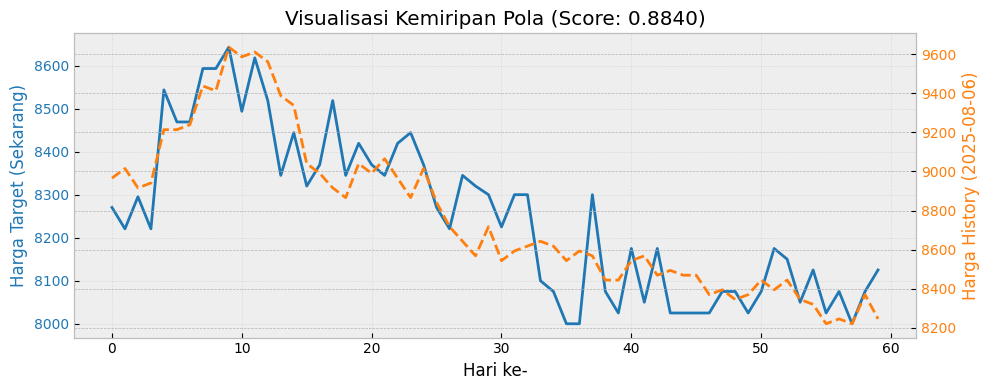

Top #2 | Date: 2025-08-08 | Score: 0.8737


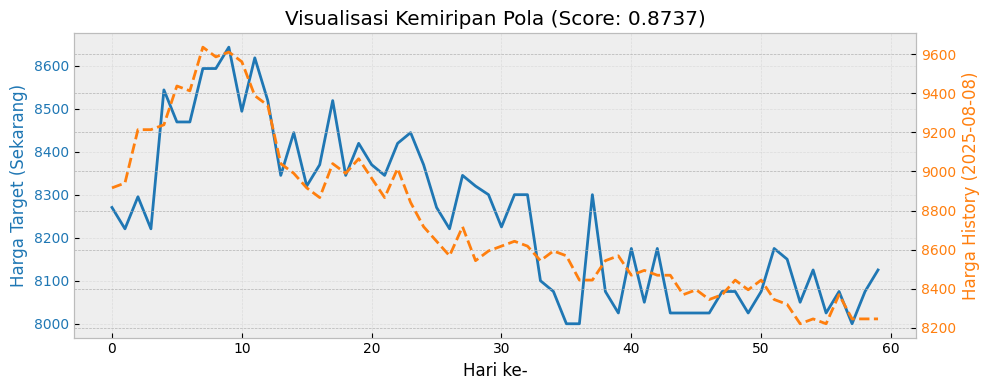

Top #3 | Date: 2025-08-07 | Score: 0.8658


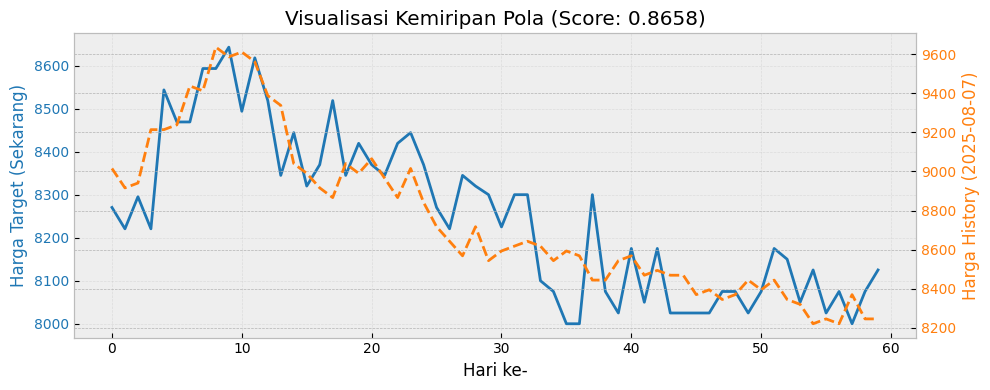

In [4]:
from sklearn.preprocessing import MinMaxScaler

data_target = df.iloc[-LOOKBACK_DAYS:]

scaler = MinMaxScaler()
pola_target = scaler.fit_transform(data_target.values.reshape(-1, 1)).flatten()

history_data = df['Close'].copy()
search_limit = len(history_data) - (LOOKBACK_DAYS * 2)

result = []

for i in range(len(history_data) - LOOKBACK_DAYS):

    history_slice = history_data.iloc[i:i + LOOKBACK_DAYS]
    pola_history = scaler.transform(history_slice.values.reshape(-1, 1)).flatten()

    correlation = np.corrcoef(pola_target, pola_history)[0, 1]

    if correlation >= 0.8:
        result.append({
            'index_start': i,
            'tanggal': history_slice.index[-1].date(),
            'score': correlation,
            'price': history_slice.values
        })
print(f"{len(result)} history slices evaluated")

result_sorted = sorted(result, key=lambda x: x['score'], reverse=True)

print(f"There's {len(result_sorted)} similar patterns found with correlation >= 0.8")

for i, res in enumerate(result_sorted[:TOP_K]):
    print(f"Top #{i+1} | Date: {res['tanggal']} | Score: {res['score']:.4f}")

    # Bikin Canvas
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # --- PLOT 1: TARGET (Sumbu Kiri - Biru) ---
    color = 'tab:blue'
    ax1.set_xlabel('Hari ke-')
    ax1.set_ylabel('Harga Target (Sekarang)', color=color)
    
    # Kita kembalikan ke harga asli biar enak dilihat
    real_target_price = scaler.inverse_transform(pola_target.reshape(-1, 1)).flatten()
    
    ax1.plot(range(LOOKBACK_DAYS), real_target_price, color=color, linewidth=2, label='Target (Sekarang)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # --- PLOT 2: HISTORY (Sumbu Kanan - Oranye) ---
    ax2 = ax1.twinx()  # INI KUNCINYA! Bikin sumbu Y kedua
    
    color = 'tab:orange'
    ax2.set_ylabel(f'Harga History ({res['tanggal']})', color=color)
    ax2.plot(range(LOOKBACK_DAYS), res['price'], color=color, linestyle='--', linewidth=2, label='History (Lama)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Judul & Layout
    plt.title(f"Visualisasi Kemiripan Pola (Score: {res['score']:.4f})")
    fig.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

TICKER ="BBRI.JK"
LOOKBACK_DAYS = 30
TRAIN_SIZE = 500

print("Download Data")
df = yf.download(TICKER, period = '5y', progress=False)

df['Return'] = df['Close'].pct_change()
df = df.dropna()

prices = df['Close'].values
returns = df['Return'].values


def historical_signal(data_target, history_data, history_return):

    scaler = MinMaxScaler()

    pola_target = scaler.fit_transform(data_target.reshape(-1, 1)).flatten()
    search_limit = len(history_data) - len(data_target) 
    matchs_next_return = []

    for i in range(0, search_limit, 2):

        history_slice = history_data[i:i + len(data_target)]
        pola_history = scaler.transform(history_slice.reshape(-1, 1)).flatten()

        try:
            correlation = np.corrcoef(pola_target, pola_history)[0, 1]
        except IndexError:
            correlation = 0

        if correlation >= 0.8:
            next_day_idx = i + len(data_target)

            if next_day_idx < len(history_return):
                next_return = history_return[next_day_idx]
                matchs_next_return.append(next_return)

    if len(matchs_next_return) > 0:
        return np.mean(matchs_next_return)
    else:
        return 0.0
        

X_dataset = []
y_dataset = []

start_idx = len(prices) - TRAIN_SIZE

if start_idx < LOOKBACK_DAYS:
    start_idx = LOOKBACK_DAYS

for i in range(start_idx, len(prices)-1):

    current_window = prices[i-LOOKBACK_DAYS : i]

    if len(current_window) != LOOKBACK_DAYS:
        continue

    history_universe_price = prices[:i-LOOKBACK_DAYS] 
    history_universe_return = returns[:i-LOOKBACK_DAYS]
    
    raf_signal = historical_signal(current_window, history_universe_price, history_universe_return)
    
    scaled_features = (current_window - current_window[0]) / current_window[0]
    features = [float(x) for x in scaled_features] + [float(raf_signal)]
    if len(features) != (LOOKBACK_DAYS + 1):
        continue

    target = returns[i]
    
    X_dataset.append(features)
    y_dataset.append(target)
    
    if len(X_dataset) % 10 == 0:
        print(f"   ⏳ Progress: {len(X_dataset)}/{TRAIN_SIZE} baris data...")

print("Dataset Siap!")

Download Data


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 10/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 20/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 30/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 40/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 50/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 60/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 70/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 80/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 90/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 100/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 110/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 120/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 130/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 140/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 150/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 160/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 170/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 180/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 190/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 200/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 210/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 220/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 230/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 240/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 250/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 260/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 270/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 280/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 290/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 300/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 310/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 320/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 330/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 340/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 350/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 360/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 370/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 380/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 390/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 400/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 410/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 420/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 430/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 440/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 450/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 460/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 470/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 480/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

   ⏳ Progress: 490/500 baris data...


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]
C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25

✅ Dataset Siap!


C:\Users\T470\AppData\Local\Temp\ipykernel_9724\2753867842.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features = [float(x) for x in scaled_features] + [float(raf_signal)]


✅ Model Terlatih!
Percobaan 1 | Seed: 7949 | Akurasi: 53.00%
🎉 New Best Model found with Arah Accuracy: 53.00%
✅ Target Arah Accuracy tercapai, menghentikan pelatihan.


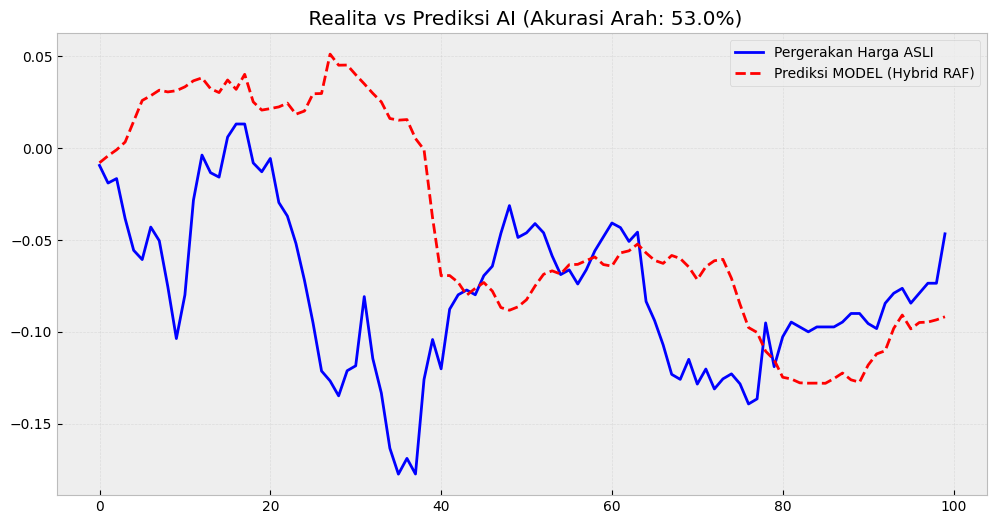

<Figure size 1000x500 with 0 Axes>

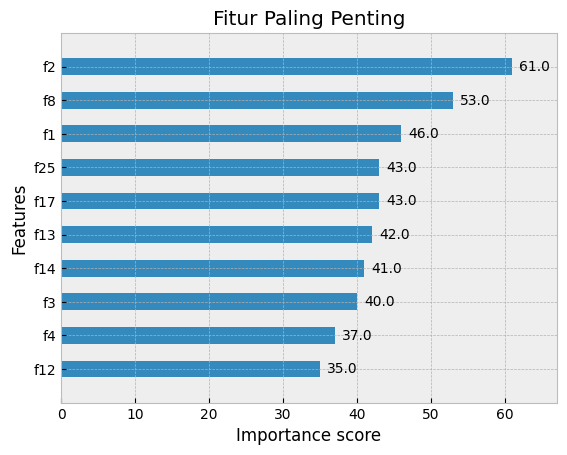

In [ ]:
import os
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = np.array(X_dataset)
y = np.array(y_dataset) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

TARGET_ACURACY = 50.0
best_akurasi = 0.0
attempt = 1

while best_akurasi < TARGET_ACURACY:

    seed = np.random.randint(0, 10000)

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=5,
        random_state=seed,
        objective='reg:squarederror'
    )

    model.fit(X_train, y_train)
    print("Model Terlatih!")

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)

    arah_predksi = np.sign(predictions)
    arah_asli = np.sign(y_test)
    akurasi_arah = np.mean(arah_predksi == arah_asli)*100

    print(f"Percobaan {attempt} | Seed: {seed} | Akurasi: {akurasi_arah:.2f}%")

    if akurasi_arah > best_akurasi:
        best_akurasi = akurasi_arah
        print(f"New Best Model found with Arah Accuracy: {best_akurasi:.2f}%")
        if best_akurasi >= TARGET_ACURACY:
            print("Target Arah Accuracy tercapai, menghentikan pelatihan.")
           

            os.makedirs('models', exist_ok=True)
            model.get_booster().save_model('models/xgb_hybrid_raf.JSON')
            break
    attempt += 1   
    if attempt > 50:
        break

plt.style.use('bmh')
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(y_test), label='Pergerakan Harga ASLI', color='blue', linewidth=2)
plt.plot(np.cumsum(predictions), label='Prediksi MODEL (Hybrid RAF)', color='red', linestyle='--', linewidth=2)

plt.title(f" Realita vs Prediksi AI (Akurasi Arah: {akurasi_arah:.1f}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Cek Feature Importance (Apakah Sejarah Berguna?)
plt.figure(figsize=(10, 5))
xgb.plot_importance(model, max_num_features=10, height=0.5, title="Fitur Paling Penting")
plt.show()